# Simulated data for DiD specifications

This notebook describes my data simulation code for *difference-in-differences* specifications. See the [did repo](https://github.com/vvoutilainen/Data_Science_Projects/tree/master/stats/did) for updated notebooks and source code.

## Notation

Assume we are measuring observations for individuals (e.g., firms) over time points $t = 0, 1, \cdots \bar{t}$. We may either have a) repeated observations for the same individuals (*panel* data) or b) new observations for (possibly) different individuals (*repeated cross-section* data). There are two distinguished groups of individuals ($j=C,T$), for example, from two different areas, with 300 ($i=0, \dots , N$) individuals in each group.

We imagine a one-off, unanticipated *policy intervention* (e.g., a government stimulus package) that affects some feature of interest (say, consumption on durables). Theoretically speaking, the treatment could apply to all individuals, but we assume an intervention that is applied only to individuals in group $j=T$, and leaves individuals in $j=C$ unaffected. The intervention takes place between time points $g$ and $g+1$, where $0 < g < \bar{t}$—or, alternatively thought, takes place during period $(g, g+1]$. We are interested in the **treatment effect** of the intervention on the feature of interest.

Let $Y_{ijt}$ denote the feature of interest (or "outcome") for individual $i$ from group $j$ at time $t$. That is, we let the feature of interest be dependent on i) individual idiosyncrasies, ii) treatment group $j$, and iii) time $t$. Further, let $D_{ijt}=\{0,1\}$ denote the treatment status (untreated, treated) and $Y_{ijt}^d$ the potential outcome at time $t$ under treatment status $D_{ijt}=d$.

## Data generating process

We follow [Zeldow & Hatfield (2021)](https://onlinelibrary.wiley.com/doi/10.1111/1475-6773.13666) (eq. 4) and propose a similar (but not quite equal) data-generating process (DGP) for the untreated potential outcomes of individuals:

$$
\begin{equation*}
    Y_{ijt}^0 = \gamma_j + \xi_t + \lambda_t X_{ijt} + \epsilon_{it}
\end{equation*}
$$

where

 - $\gamma_j$ is a constant, group-specific, time-invariant effect;  
 - $\xi_t$ is a time-specific effect (affecting all individuals/groups in the same way). In the code, it can be specified as a lambda function with $t$ as an argument;
 - $\lambda_t X_{ijt}$ is an individual-group-time specific effect. $\lambda_t$ denotes the time-varying effect of $X_{ijt}$ (notice that $\lambda_t$ is not allowed to vary across groups $j$). We allow for the following specifications:
   - (X1): Time-invariant covariate, time-invariant covariate effect: $\lambda_t X_{ijt} = X_{ij} \sim N(\mu_j, \sigma_j^2)$ for all $t$. That is, the term affects the outcome in individual-and-group specific (time-invariant) way. Notice that the covariate is a confounder in cross-section dimension only if $\mu_C \neq \mu_T$. If $\mu_C = \mu_T$, then (average) overlap of $X_{ij}$ between groups is the same and we have that the term affects the outcome in individual specific (treatment-and-time-invariant) way only (if variances differ between groups, it might affect efficiency, however).
   - (X5a): Time-variant covariate (divergent evolution), time-invariant covariate effect: $\lambda_t X_{ijt} = X_{ij} +  \alpha_j t $ where $X_{ij} \sim N(\mu_j, \sigma_j^2)$. The covariates between groups $j$ have a divergent evolution as long as $\alpha_T \neq \alpha_C$. Covariate may or may not be a confounder in cross-section (depending on whether $\mu_C = \mu_T$ or not), but this does not matter. The main point is that the evolution of the covariate between groups differs.
   - **Rest from Appendix D of [Zeldow & Hatfield (2021)](https://onlinelibrary.wiley.com/doi/10.1111/1475-6773.13666) to be filled**;
 - $\epsilon_{it}$ denote individual-and-time-specific idiosyncrasies, modelled as $\epsilon_{it} \sim N(0, \sigma^2_e)$.

The effect of the intervention is modeled as an additive effect. The DGP for the treated potential outcomes is

$$
\begin{equation*}
    Y_{ijt}^1 = Y_{ijt}^0 + \tau_{jt} ,
\end{equation*}
$$

where $\tau_{jt}$ is the (possibly group- and time-dependend) treatment effect. Due to the assumption that treatment applies only to individuals in group $j=T$, we have that $\tau_{Ct} = 0$ for all $t$. For group $j=T$, due to our non-anticipation assumption, treatment does not affect the treatment group in the pre-period. Accordingly, we allow the following treatment effects for the individuals in the treated group:

 - constant treatment effect: $\tau_{jt} = \tau \ \unicode{x1D7D9}_{t>g}$ (where $\unicode{x1D7D9}_{t>g}$ is an indicator function receiving value 1 when $t>g$);
 - linearly evolving treatment effect: $\tau_{jt} = \tau \ (t-g) \ \unicode{x1D7D9}_{t>g}$.

The observed outcome for any individual $i$ can now be written as

$$
\begin{equation*}
    Y_{ijt} = D_{ijt} Y_{ijt}^1 + (1-D_{ijt}) Y_{ijt}^0
\end{equation*}
$$

Note some differences compared to [Zeldow & Hatfield (2021)](https://onlinelibrary.wiley.com/doi/10.1111/1475-6773.13666):

 - Our $\gamma_j$ corresponds to their $\alpha_0 + \alpha_1 di$ in the following way: $\gamma_C = \alpha_0$ and $\gamma_T = \alpha_0 + \alpha_1$;
 - Their specification lets $X$ be dependent on individual *i*'s past history (scenarios 4-6, assuming panel data). In our DGP, the time-varying $X$ is not allowed to have such property (at least not yet), as the DGPs for panel and repeated cross-section data are basically the same.

Our DGP does not currently allow

 - varying covariate effect across treatment groups, i.e., $\lambda_t^j$. This might be an interesting addition, and is not supported in [Zeldow & Hatfield (2021)](https://onlinelibrary.wiley.com/doi/10.1111/1475-6773.13666);
 - staggered treatment adoption. See the [did](https://github.com/bcallaway11/did) R package by Brantly Callaway and Pedro H.C. Sant’Anna.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
import rpy2
%load_ext rpy2.ipython
from did_helpers import(
    simulate_did_data,
    plot_repcrossec_data,
    plot_panel_data,
)

## Panel example

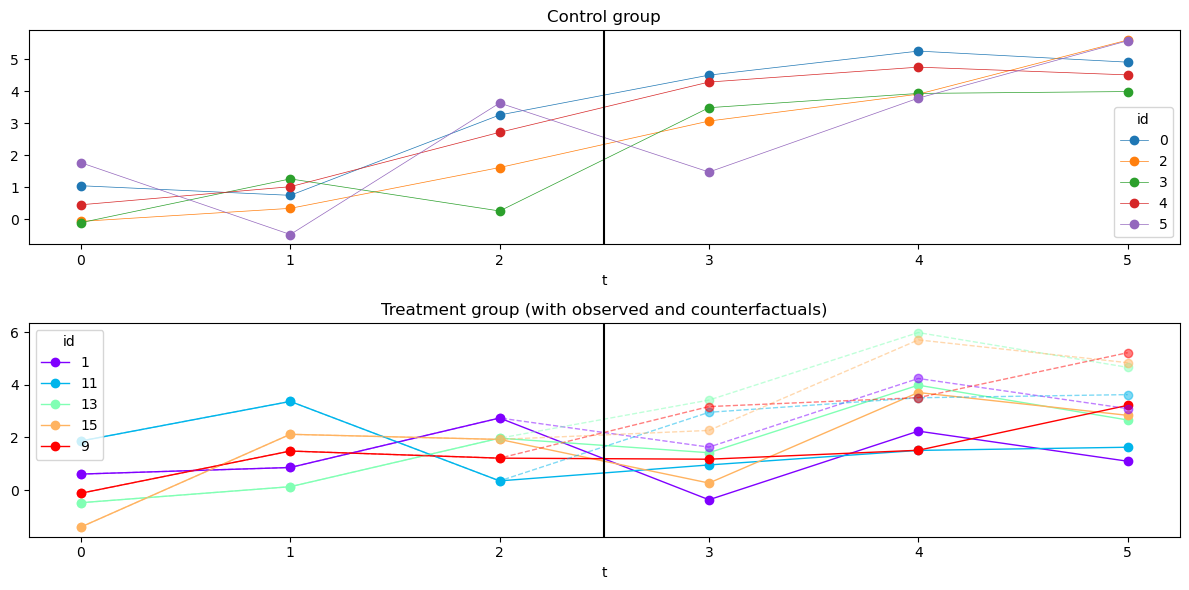

In [2]:
out_panel = simulate_did_data(param_datasettype="panel")
plot_panel_data(
    out_panel,
    selected_individuals=(
        out_panel["observed"].query("treatment_group=='control'")["id"].head(5).tolist() +
        out_panel["observed"].query("treatment_group=='treatment'")["id"].head(5).tolist()
    )
)

## Repeated cross-section example

Realized control pre-period mean 1.038
Realized control post-period mean 4.028
Realized treated pre-period mean 0.966
Realized treated post-period mean 1.951
Counterfactual (unobserved) treatment post-period mean 3.951
Counterfactual (naively estimated) treated post-period mean 3.956
Naive DiD-estimate -2.004


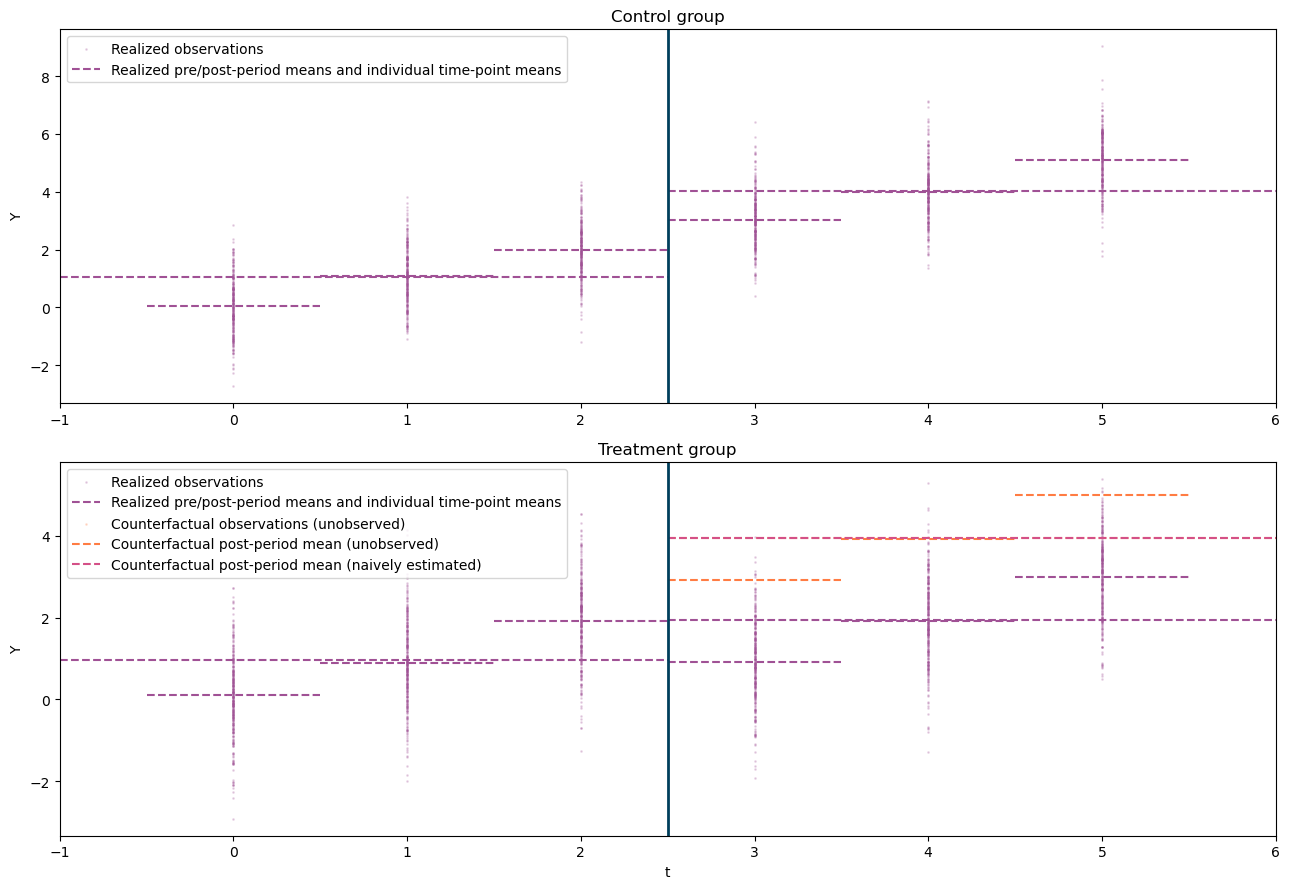

In [3]:
out_rpc = simulate_did_data(param_datasettype="repeated cross-section")
plot_repcrossec_data(out_rpc)